# Dog Breeds Kaggle Competition -- fast.ai

## Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogbreed/"
image_size=224
arch=resnext101_64
batch_size=64

In [5]:
label_csv = f'{PATH}labels.csv'
num_labels = len(list(open(label_csv)))-1

In [6]:
# create a set of validation indices (i.e. indices not used for training -- by default it gets 20% of total for validation)
val_idxs = get_cv_idxs(num_labels)

## Data Exploration

In [7]:
!ls {PATH}

DSCF4002.JPG  labels.csv.zip		 test	   tmp	  train.zip
labels.csv    sample_submission.csv.zip  test.zip  train


In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [11]:
# Use data augmentatioin on training images
tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [12]:
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=batch_size)

In [13]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

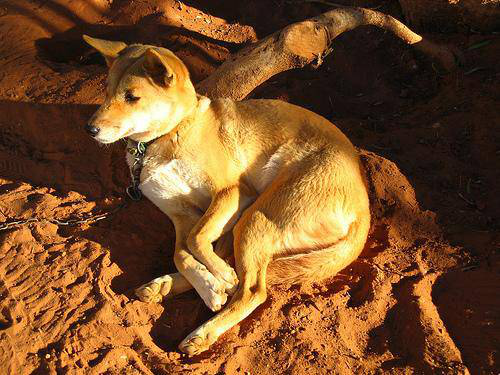

In [14]:
img = PIL.Image.open(fn); img

In [15]:
img.size

(500, 375)

In [16]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [17]:
row_size,col_size = list(zip(*size_d.values()))
row_size = np.array(row_size); col_size = np.array(col_size)

In [18]:
row_size[:5]

array([500, 500, 500, 500, 500])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

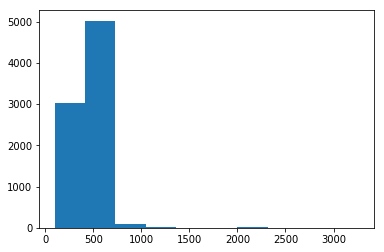

In [19]:
plt.hist(row_size)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

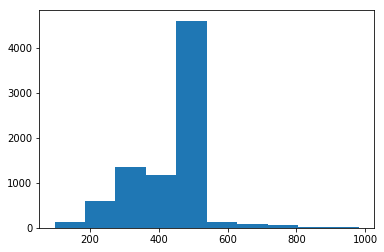

In [20]:
# plot histogram of row_sizes less than 1000
plt.hist(row_size[row_size<1000])

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

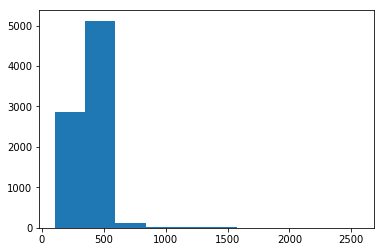

In [21]:
plt.hist(col_size)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

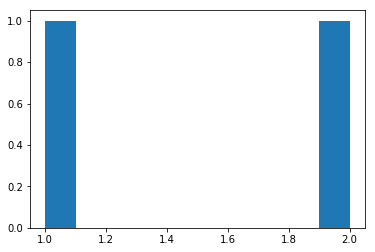

In [53]:
plt.hist([1.0, 2.0])

(array([ 361., 1258., 1622., 4630.,  158.,   69.,   15.,   13.,    1.,    7.]),
 array([  97. ,  215.3,  333.6,  451.9,  570.2,  688.5,  806.8,  925.1, 1043.4, 1161.7, 1280. ]),
 <a list of 10 Patch objects>)

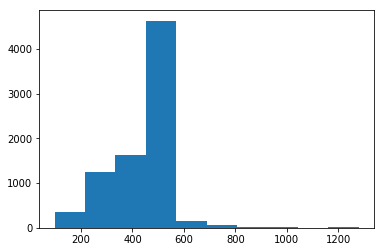

In [22]:
plt.hist(row_size[col_size<1000])

In [23]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [24]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial Model

In [25]:
# changed num_workers to 8 to match num GPUs?
def get_data(arch, image_size, batch_size):
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=8,
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=batch_size)
    return data if image_size > 300 else data.resize(340, 'tmp')

### Choose a learning rate

In [26]:
data = get_data(arch, image_size, batch_size)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|███████▉  | 102/128 [00:02<00:00, 40.51it/s, loss=14.3]


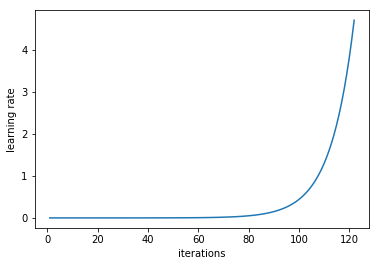

In [29]:
learn.sched.plot_lr()

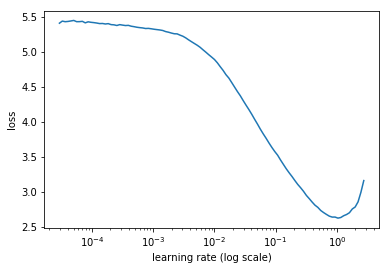

In [30]:
learn.sched.plot()

In [31]:
learn_rate = 1e-1

### Precompute

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
learn.fit(learn_rate, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.703637   0.427469   0.883626  
    1      0.408568   0.373502   0.897363                    
    2      0.257514   0.399464   0.89681                     



[0.39946377, 0.896809896454215]

### Augment

In [ ]:
learn.precompute = False

In [ ]:
learn.fit(learn_rate, 2, cycle_len=1)

In [ ]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

### Increase Image Size

In [ ]:
image_size = 299
learn.set_data(get_data(arch, image_size, batch_size))
learn.freeze()

In [ ]:
learn.fit(learn_rate, 2, cycle_len=1)

In [ ]:
learn.fit(learn_rate, 3, cycle_len=1, cycle_mult=2)

### Test Time Augmentation

In [34]:
log_preds,y = learn.TTA()

In [35]:
probs = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

(0.34378565767415786, 0.9006849315068494)

In [ ]:
learn.save('299_pre')

In [ ]:
learn.load('299_pre')

In [ ]:
learn.fit(learn_rate, 1, cycle_len=2)

In [ ]:
learn.save('dogbreed_299')

### Analyzing results: looking at pictures

In [42]:
# This is the label for a val data
data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [43]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [44]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2044, 120)

In [45]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)        # pr(dog)

In [46]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [47]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [48]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    #title_probs = [data.val_ds.fnames[x] for x in idxs]
    title_probs = [probs[x][np.argmax(probs[x])] for x in idxs]
    print(title + ":" + data.val_ds.fnames[idxs[0]])
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified:train/586f6c70898d463676f8e6e1e2b96b1d.jpg


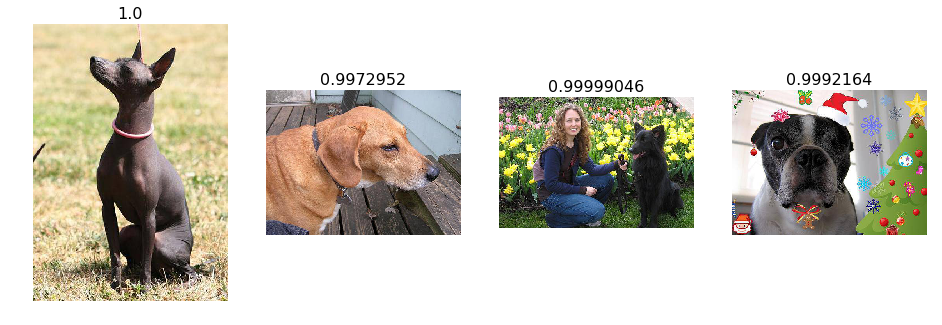

In [49]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified:train/b8241dace56c5a7ead41326a6417ab65.jpg


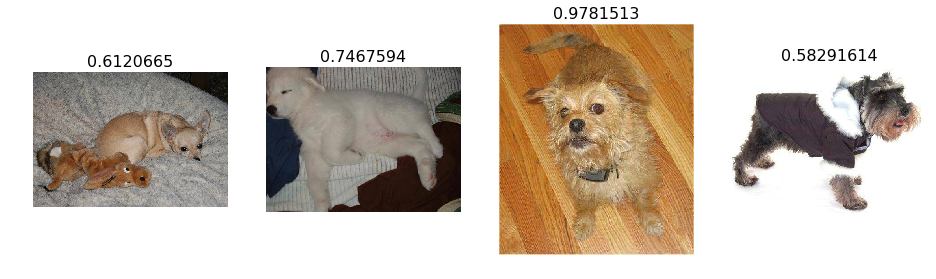

In [50]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

### Try to predict breed of single dog image

In [42]:
# need to call learn.predict() at least once before using learn.predict_array(), or you seem to get incorrect results
#learn.precompute = False
log_preds = learn.predict()

train/000bec180eb18c7604dcecc8fe0dba07.jpg


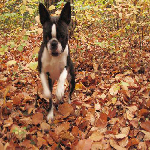

In [54]:
#fn = "DSCF4002.JPG"
fn = data.val_ds.fnames[0]; print(fn)
#fn = "train/586f6c70898d463676f8e6e1e2b96b1d.jpg"
im = Image.open(PATH+fn).resize((150,150)); im

In [55]:
trn_tfms,val_tfms = tfms_from_model(arch, image_size)
tfim = val_tfms(np.array(im))
learn.precompute = False
single_image_preds = learn.predict_array(tfim[None])

In [56]:
learn.data.classes[np.argmax(single_image_preds)]

'boston_bull'

In [57]:
sorted_idx = (np.argsort(single_image_preds[0]))[::-1][:5]

In [58]:
for i in sorted_idx :
    print("{1:0.2f}%: {0:s} ".format(learn.data.classes[i], np.exp(single_image_preds[0][i])*100.0))

99.97%: boston_bull 
0.02%: boxer 
0.00%: french_bulldog 
0.00%: pug 
0.00%: japanese_spaniel 
